In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [10]:
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()

In [21]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

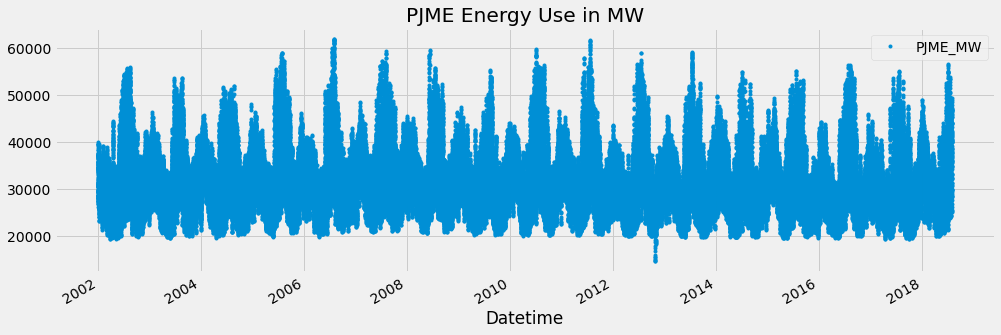

In [28]:
df.plot(style = '.', figsize = (15,5), color = color_pal[0],title= 'PJME Energy Use in MW')
plt.show()

## Train and Split

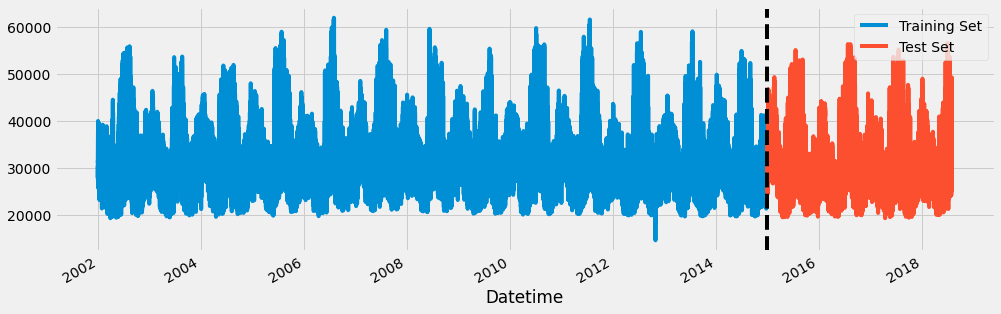

In [29]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5) )
train.plot(ax = ax, label = 'Training Set')
test.plot(ax = ax, label = 'Test Set')
plt.axvline('01-01-2015', color = 'black', ls = '--')
plt.legend(["Training Set", "Test Set"])
plt.show()

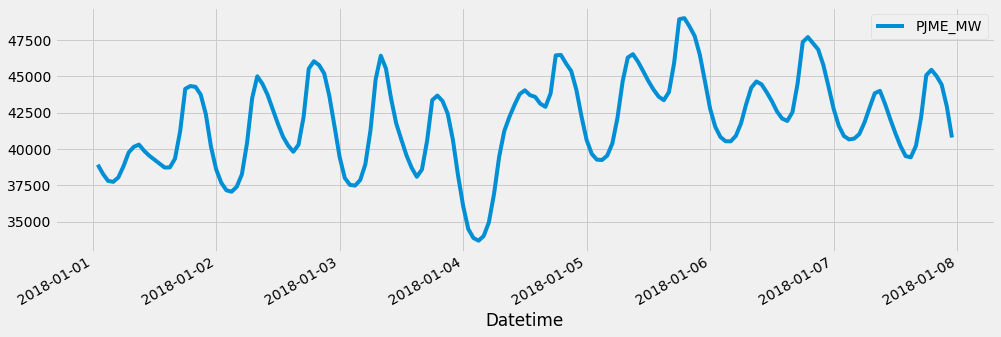

In [37]:
# plotting one week of data
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')].plot(figsize = (15,5))
plt.show()

## Feature Creation

In [59]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.day_of_year
    return df

In [46]:
df = create_features(df)

## Visualize our Feature / Target Relationship

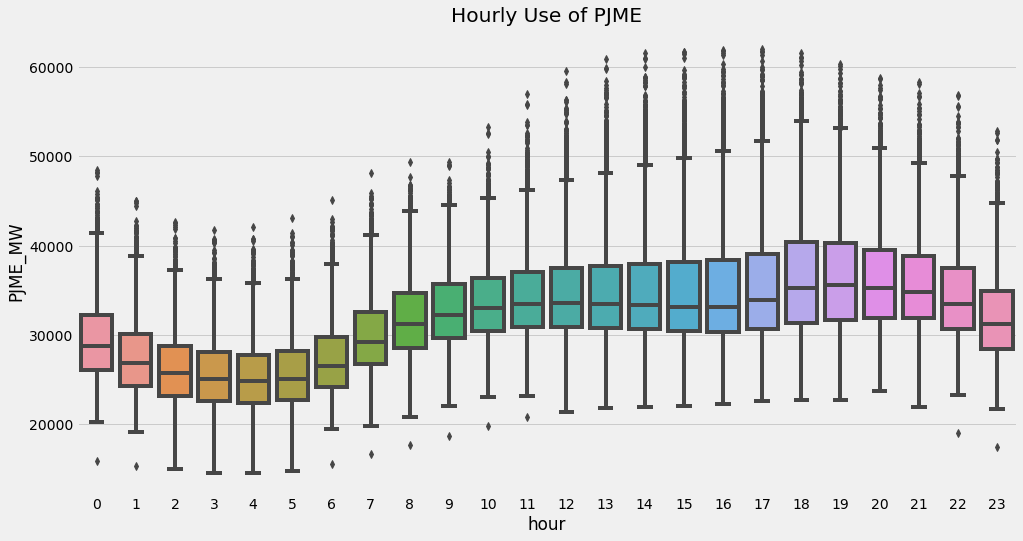

In [53]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
plt.title('Hourly Use of PJME')
plt.show()

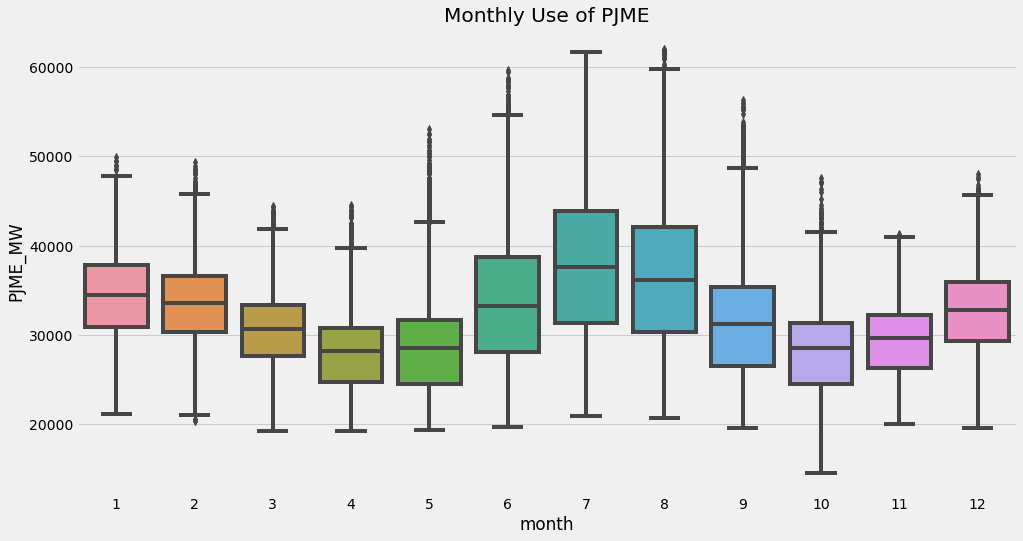

In [55]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data = df, x = 'month', y = 'PJME_MW')
plt.title('Monthly Use of PJME')
plt.show()

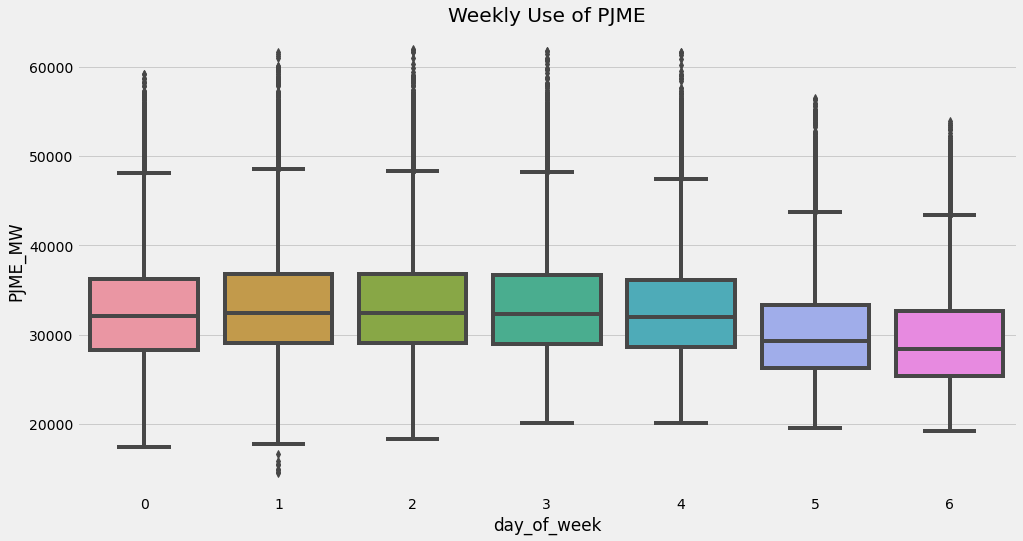

In [56]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(data = df, x = 'day_of_week', y = 'PJME_MW')
plt.title('Weekly Use of PJME')
plt.show()

## Model Creation

In [62]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year']
TARGET = ['PJME_MW']

In [66]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [70]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, 
                      learning_rate = 0.01)
reg.fit(X_train, y_train, 
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance

In [72]:
fi = pd.DataFrame(data = reg.feature_importances_,
            index = reg.feature_names_in_,
            columns = ['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

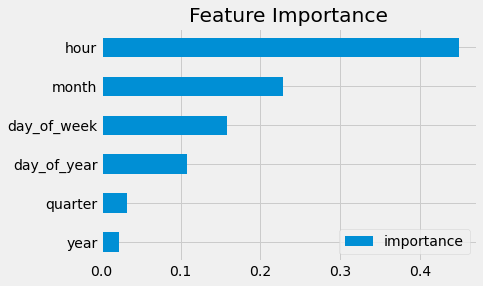

In [74]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')

## Forecast on Test

In [84]:
test["prediction"] = reg.predict(X_test)

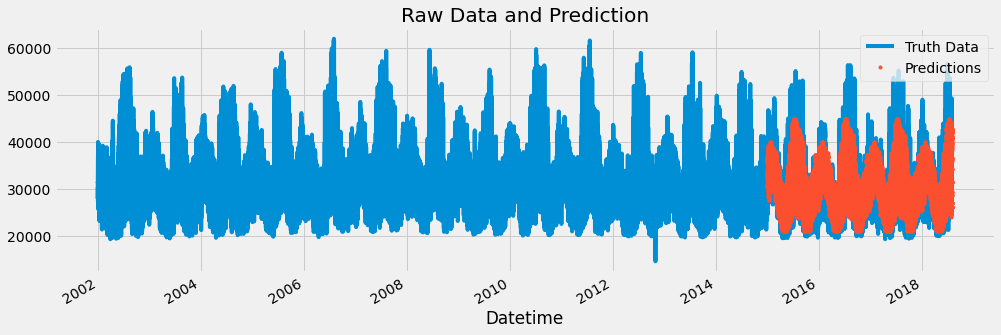

In [85]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index =True)
ax = df[["PJME_MW"]].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title("Raw Data and Prediction")
plt.show()

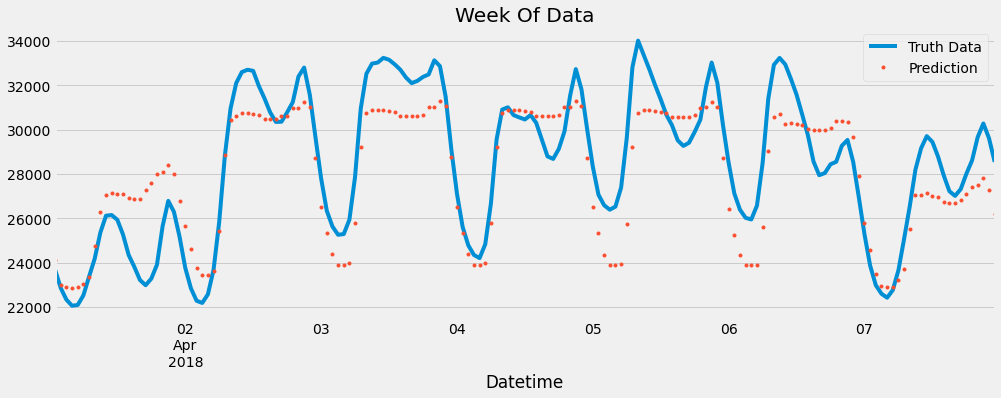

In [86]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [87]:
score = np.sqrt(mean_squared_error(test["PJME_MW"], test["prediction"]))
score

3715.9314164142415

## Calculate Error

In [94]:
test['error'] = np.abs(test["PJME_MW"] - test["prediction"])

In [96]:
test['date'] = test.index.date

In [101]:
test.groupby('date')['error'].mean().sort_values(ascending = False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [102]:
test.groupby('date')['error'].mean().sort_values(ascending = True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64